In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Spam Email Classification Model

In [ ]:
# importing system libraries

from os import walk
from string import punctuation
from random import shuffle
from collections import Counter

# importing additional libraries

import pandas as pd
import sklearn as sk
import nltk

In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile('/content/drive/MyDrive/Dataset/Enron Dataset/archive.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('/content/drive/MyDrive/Dataset/Enron Dataset')

In [ ]:
# Read the whole data from the Enron Dataset into a variable allData.

pathwalk = walk(r"/content/drive/MyDrive/Dataset/Enron Dataset")

allHamData, allSpamData = [], []
for root, dr, file in pathwalk:
    if 'ham' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allHamData.append(" ".join(ip.readlines()))
                
    elif 'spam' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allSpamData.append(" ".join(ip.readlines()))

In [ ]:
# remove all redundent data

allHamData = list(set(allHamData))
allSpamData = list(set(allSpamData))

In [ ]:
# storing it in a dataframe

hamPlusSpamData = allHamData + allSpamData
labels = ["ham"]*len(allHamData) + ["spam"]*len(allSpamData)

raw_df = pd.DataFrame({"email": hamPlusSpamData, 
                       "label": labels})

In [ ]:
# checking how it looks

raw_df.sample(5)

,email,label
21138,Subject: ( otcbb : necx ) alternative energy c...,spam
24119,Subject: fw : 2 minutes to read what i have to...,spam
19221,"Subject: spyglass\n maxine , . . . . nightdres...",spam
9800,Subject: last call for accountants . . . . .\n...,ham
9849,Subject: re : ena sales on hpl\n daren - thank...,ham


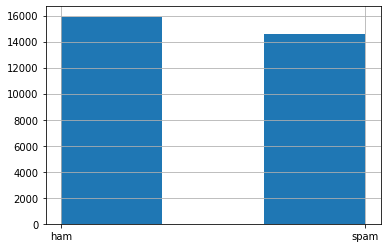

In [ ]:
# get an overview of the data

raw_df.label.hist(bins=3)

# NLTK's Naive Bayes Classifier
### with custom text pre-processor using NLTK's word_tokenize and WordNetLemmatizer

In [ ]:
# creating a preprocessing function
# to tokenize and lemmatize the data using NLTK library

def preprocess(data):
    # tokenization
    tokens = nltk.word_tokenize(data)
    tokens = [w.lower() for w in tokens if w.isalpha()]

    # finding uncommon words
    cnt = Counter(tokens)
    uncommons = cnt.most_common()[:-int(len(cnt)*0.1):-1]
    
    # listing stopwords from NLTK
    stops = set(nltk.corpus.stopwords.words('english'))

    # removing stop words and uncommon words
    tokens = [w for w in tokens if (w not in stops and w not in uncommons)]

    # lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w, pos='a') for w in tokens]

    return tokens

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# pre-processing the emails
# using word_tokenize() and WordNetLemmatizer()

nltk_processed_df = pd.DataFrame()
nltk_processed_df['email'] = [preprocess(e) for e in raw_df.email]

In [ ]:
# label encoding the labels

label_encoder = sk.preprocessing.LabelEncoder()
nltk_processed_df['label'] = label_encoder.fit_transform(raw_df.label)

In [ ]:
# checking how the processed data looks like

nltk_processed_df.sample(5)

,email,label
1745,"[subject, california, update, though, announce...",0
18931,"[subject, inexpensive, software, looking, inex...",1
5050,"[subject, tenaska, agreement, darren, know, si...",0
15624,"[subject, california, capacity, report, week, ...",0
540,"[subject, cusip, david, cusip, bond, efo, pgc,...",0


In [ ]:
# converting categorical email data to numerical data using Counters

X, y = nltk_processed_df.email, nltk_processed_df.label
X_featurized = [Counter(i) for i in X]

In [ ]:
# getting the data ready for NaiveBayesClassifier 
# randomizing using shuffle
# manually splitting into test and train data

allDataProcessed = [(X_featurized[i], y[i]) for i in range(len(X))]

shuffle(allDataProcessed)

trainData, testData = allDataProcessed[:int(len(allDataProcessed)*0.7)], allDataProcessed[int(len(allDataProcessed)*0.7):]

In [ ]:
# Training the model

model_nltkNaiveBayes = nltk.classify.NaiveBayesClassifier.train(trainData)

In [ ]:
# Testing the model

testing_accuracy = nltk.classify.accuracy(model_nltkNaiveBayes, testData)
print("Accuracy with NLTK's Naive Bayes classifier is:", testing_accuracy)

Accuracy with NLTK's Naive Bayes classifier is: 0.9879755137735025


# Scikit-learn's Multinomial Naive Bayes Classifier
### with CountVectorizer and TfidfVectorizer comparison

In [ ]:
# Vectorize the features using CountVectorizer

cv_vec = sk.feature_extraction.text.CountVectorizer(tokenizer = nltk.word_tokenize, 
                                                    stop_words = nltk.corpus.stopwords.words("english"))

cv_X = cv_vec.fit_transform(raw_df.email)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
# Vectorize the features using TfidfVectorizer

tfidf_vec = sk.feature_extraction.text.TfidfVectorizer(tokenizer = nltk.word_tokenize, 
                                                    stop_words = nltk.corpus.stopwords.words("english"))

tdidf_X = cv_vec.fit_transform(raw_df.email)

In [ ]:
# label encode the labels using LabelEncoder

label_encoder = sk.preprocessing.LabelEncoder()
y = label_encoder.fit_transform(raw_df.label)

In [ ]:
# loading the MultinomialNB model

from sklearn.naive_bayes import MultinomialNB
model_sklearn_mnb = MultinomialNB()

In [ ]:
# getting cross validation score on count-vectorized features
# getting cross validation score on tfidf processed features

cv_score = sk.model_selection.cross_validate(model_sklearn_mnb, cv_X, y)

tfidf_score = sk.model_selection.cross_validate(model_sklearn_mnb, tdidf_X, y)

In [ ]:
# checking the scores by putting them into a dataframe first

sklearn_scores = pd.DataFrame([cv_score, tfidf_score], index=['CountVetorizer', 'TfidfVectorizer'])
sklearn_scores = sklearn_scores.applymap(lambda x: x.mean())

sklearn_scores

,fit_time,score_time,test_score
CountVetorizer,0.036056,0.006488,0.98416
TfidfVectorizer,0.034966,0.006157,0.98416
